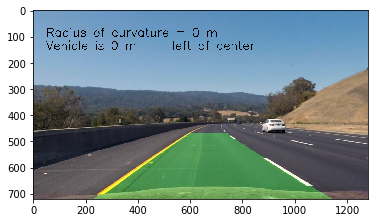

In [10]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pickle



#funktion for a sobel Filter

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)): 
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    else:
        sobel=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobel=np.absolute(sobel)
    scaled_sobel=np.uint8(255*abs_sobel/np.max(abs_sobel))  
    binary_output=np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>=thresh[0])&(scaled_sobel<=thresh[1])]=1
    
    return binary_output


#Funktion for a S(hls) and V(hsv) filter

def sv_filter(image,thresh_s,thresh_v):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    V=hsv[:,:,2]
    
    binary_sv = np.zeros_like(S)
    #binary_hls[(S > thresh_s[0]) & (S <= thresh_s[1])] = 1
    
    #binary_v = np.zeros_like(V)
    binary_sv[(V > thresh_v[0]) & (V <= thresh_v[1]) & (S > thresh_s[0]) & (S <= thresh_s[1])] = 1
    
    return binary_sv


#Funktion for a finding lane lines with sliding window method

def find_lane_pixels(binary_warped):

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    margin = 200
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):

        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = int(leftx_current-margin/2) 
        win_xleft_high = int(leftx_current+margin/2)
        win_xright_low = int(rightx_current-margin/2)
        win_xright_high = int(rightx_current+margin/2)
        
        good_left_inds = ((nonzeroy>=win_y_low)&(nonzeroy<=win_y_high)&
                          (nonzerox>=win_xleft_low)&(nonzerox<=win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy>=win_y_low)&(nonzeroy<=win_y_high)&
                          (nonzerox>=win_xright_low)&(nonzerox<=win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds)>minpix:
            leftx_current=np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>minpix:
            rightx_current=np.int(np.mean(nonzerox[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:

        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    

    #if not enough pixel were found, artifical values would be used in order to avoid an error (imitating of straight lines)
    
    if len(leftx)<2:
        leftx=[0.2*binary_warped.shape[1],0.2*binary_warped.shape[1]]
    if len(lefty)<2:
        lefty=[binary_warped.shape[0],0]
    if len(rightx)<2:
        rightx=[0.8*binary_warped.shape[1],0.8*binary_warped.shape[1]]
    if len(righty)<2:
        righty=[binary_warped.shape[0],0]
    return leftx, lefty, rightx, righty


# Funktion for a fitting polynomials between founded pixels (used only after sliding window method)

def fit_polynomial(binary_warped): 
    global leftx,lefty,rightx,righty
    leftx, lefty, rightx, righty = find_lane_pixels(binary_warped) 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:

        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit



# Funktion for a fitting polynomials between founded pixels (used only 
# after the method, wich searches around already founded polynomials)

def fit_polynomial_around(binary_warped, leftx, lefty, rightx, righty):
    

        
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:

        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fitx, right_fitx, ploty, left_fit, right_fit



# Funktion wich find a lane lines pixels around the already founded polynomials

def search_around_poly(binary_warped, left_fit, right_fit, margin = 90):
    global leftx,lefty,rightx,righty
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
        
    left_margin1 = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]-margin
    left_margin2 = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]+margin
    right_margin1 = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]-margin
    right_margin2 = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]+margin
    
    left_lane_inds = ((nonzerox >= left_margin1) & (nonzerox <= left_margin2))
    right_lane_inds = ((nonzerox >= right_margin1) & (nonzerox <= right_margin2))

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # if no pixels were founded, get back to the sliding window approach
    if len(leftx) or len(lefty) or len(rightx) or len(righty)<2:
        leftx, lefty, rightx, righty=find_lane_pixels(binary_warped)

    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial_around(binary_warped, leftx, lefty, rightx, righty)
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

# funktion for finding values of the curvature and the offset 

def find_parameters(leftx,lefty,rightx,righty,ploty,left_fitx, right_fitx):
        
    ym_per_pix = 30/image.shape[0]
    xm_per_pix = 3.7/700
    
    left_cr=np.polyfit(np.array(lefty,np.float32) * ym_per_pix,np.array(leftx,np.float32) * xm_per_pix, 2)
    right_cr=np.polyfit(np.array(righty,np.float32) * xm_per_pix, np.array(rightx,np.float32) * xm_per_pix, 2)
    y_eval=np.max(ploty)
    left_curve=((1+(2*left_cr[0] * y_eval * ym_per_pix + left_cr[1])**2)**1.5/np.absolute(2*left_cr[0]))
    right_curve=((1+(2*right_cr[0] * y_eval * ym_per_pix+right_cr[1])**2)**1.5/np.absolute(2*right_cr[0]))
    curve=(left_curve+right_curve)/2
    dist=((left_fitx[-1]+right_fitx[-1])/2-image.shape[1]/2)*xm_per_pix
    
    
    return curve, dist, left_curve, right_curve

def process_image(image):
    global left_middle, right_middle, left_fitx_prv, right_fitx_prv, left_fit, right_fit
    
    # undistorting the image with a matrix, created at "Camera Calibration" file

    mtx=dist_pickle['mtx']
    dist=dist_pickle['dist']
    image=cv2.undistort(image,mtx,dist,None,mtx)

    original=np.copy(image)
    x=image.shape[1]
    y=image.shape[0]
    
    #applying the filter funktions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=7, thresh=(25, 100)) 
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=7, thresh=(25, 100)) 
    sv_image = sv_filter(image,thresh_s = (100, 255),thresh_v = (50,255))
    
    # combinig the pixels, wich were founded due to filters
    combined = np.zeros_like(sv_image)
    combined[((gradx == 1) & (grady == 1) | (sv_image== 1))]=255
    
    # setting points for ROI
    a=(int(0.03*x),y)
    b=(int(0.442*x),int(0.65*y))
    c=(int(0.59*x),int(0.65*y))
    d=(int(0.98*x),y)
    
    # making a "Bird eye view" using points for roi
    src=np.float32([a,b,c,d])
    dst=np.float32([[int(0.1*x),y],[int(0.1*x),0],[int(0.9*x),0],[int(0.9*x),y]])
    M=cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(combined,M,(x,y),flags=cv2.INTER_LINEAR)

    
    # at the start using a slinding window approach,
    #and then looking dor a pixels near the already founded polynomials
    if len(left_middle)==0:
        left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(warped)
    else:
        left_fitx, right_fitx, ploty, left_fit, right_fit = search_around_poly(warped, left_fit, right_fit, margin = 100)
    
    
    # finding values of the curvature and the offset 
    curve, dist, left_curve, right_curve=find_parameters(leftx,lefty,rightx,righty,ploty,left_fitx, right_fitx)
    
    # making not every value to be schown, but every -n value, to smooth the display of values on the video
    curve_smooth.append(curve)
    dist_smooth.append(dist)
    if len(curve_smooth)>2*smooth_level-1:
        del curve_smooth[0:smooth_level]
        del dist_smooth[0:smooth_level]

    curve=curve_smooth[(smooth_level-1)]
    dist=dist_smooth[(smooth_level-1)]
    
    
    #smoothing the polynomials values by adding avery new founded polynomial to a list and then taking
    # an average value from it
    
    left_middle.append(left_fitx)
    right_middle.append(right_fitx)    

    if len(left_middle)>smooth_level+1:
        del left_middle[0]
        del right_middle[0]
    
    left_fitx_cur=np.mean(left_middle, axis=0)
    right_fitx_cur=np.mean(right_middle, axis=0)
   

    # Connecting two founded lines wwith a green background
    window_img = np.zeros_like(np.dstack((warped,warped,warped))*255)
    left_line_w = np.array([np.transpose(np.vstack([left_fitx_cur, ploty]))])#><
    right_line_w = np.array([np.flipud(np.transpose(np.vstack([right_fitx_cur, ploty])))])
    line_pts = np.hstack((left_line_w, right_line_w))
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))

    # bringing the picture back from "Bird eye view" to the normal
    Minv=cv2.getPerspectiveTransform(dst,src)
    result = cv2.warpPerspective(window_img,Minv,(x,y),flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(original, 1, result, 0.3, 0)
    
    # displying the parameter values
    if dist>=0:
        sub='left'
    else:
        sub='right'
    cv2.putText(result,'Radius of curvature = '+str(round(curve,3))+' m',(50,100),cv2.FONT_HERSHEY_SIMPLEX,1.5,(0,0,0),2)
    cv2.putText(result,'Vehicle is '+str(round(np.absolute(dist),3))+' m ',(50,150),cv2.FONT_HERSHEY_SIMPLEX,1.5,(0,0,0),2)
    cv2.putText(result, sub +' of center',(530,150),cv2.FONT_HERSHEY_SIMPLEX,1.5,(0,0,0),2)
    

    
    return result


image=mpimg.imread('test_images/test3.jpg.')
dist_pickle=pickle.load(open('calibration_pickel.p','rb'))

smooth_level=3
curve_smooth=[0]*smooth_level
dist_smooth=[0]*smooth_level
left_middle=[]
right_middle=[]
result=process_image(image)
plt.imshow(result)




In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

dist_pickle=pickle.load(open('calibration_pickel.p','rb'))
mtx=dist_pickle['mtx']
dist=dist_pickle['dist']
left_middle=[]
right_middle=[]
smooth_level=3
curve_smooth=[0]*smooth_level
dist_smooth=[0]*smooth_level

white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(15,20)
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
    fig=plt.figure(figsize=(28,28))
    cv2.line(result,a,b,(255,0,0),2)
    cv2.line(result,b,c,(255,0,0),2)
    cv2.line(result,c,d,(255,0,0),2)
    cv2.line(result,d,a,(255,0,0),2)
    ax1=fig.add_subplot(321)
    ax2=fig.add_subplot(322)
    ax3=fig.add_subplot(323)
    ax4=fig.add_subplot(324)

    ax1.imshow(cc)
    ax2.imshow(result)
    ax3.imshow(warped, cmap='gray')
    ax4.imshow(combined,cmap='gray')

In [ ]:
    if np.absolute(left_curve-right_curve) <= max(left_curve, right_curve)/5 \
    and np.absolute(max(left_fit[0],right_fit[0])/min(left_fit[0],right_fit[0]))<=10:  

        left_middle.append(left_fitx)
        right_middle.append(right_fitx)
        left_fitx_prv=left_fitx
        right_fitx_prv=right_fitx
        
    elif np.absolute(left_curve-right_curve) > max(left_curve, right_curve)/5 and len(left_middle)>0:
        
        left_middle.append(left_fitx_prv)
        right_middle.append(right_fitx_prv)
        
    elif np.absolute(left_curve-right_curve) > max(left_curve, right_curve)/5 and len(left_middle)<1:
        
        left_middle.append(left_fitx)
        right_middle.append(right_fitx)
        left_fitx_prv=left_fitx
        right_fitx_prv=right_fitx
                
